In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [3]:
import os
import glob
import random
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from src.text_detection.net import *
from src.text_detection.loss import *
from src.text_detection.data import *
from src.text_detection.utils import *
from src.text_detection.lit_net import *
from src.text_detection.inference import *

# random.seed(42)

In [4]:
DATA_DIR_RAW = "../data/raw"
DATA_DIR_RAW_TRAIN = f"{DATA_DIR_RAW}/train"
DATA_DIR_RAW_TEST = f"{DATA_DIR_RAW}/test"
DATA_DIR_ANNOTATION_TRAIN = f"{DATA_DIR_RAW}/train"
DATA_DIR_ANNOTATION_TEST = f"{DATA_DIR_RAW}/test"

In [5]:
TRAIN_IMAGES = glob.glob(f"{DATA_DIR_RAW_TRAIN}/*.jpg")
TRAIN_OCR_ANNOTATIONS = [_ for _ in glob.glob(f"{DATA_DIR_ANNOTATION_TRAIN}/*.json") if "_ocr" in _]
TEST_IMAGES = glob.glob(f"{DATA_DIR_RAW_TEST}/*.jpg")
TEST_OCR_ANNOTATIONS = [_ for _ in glob.glob(f"{DATA_DIR_ANNOTATION_TEST}/*.json") if "_ocr" in _]

print(f"There are altogether {len(TRAIN_IMAGES)} images in the train directory.")
print(f"Corresponding to these, there are {len(TRAIN_OCR_ANNOTATIONS)} annotations in the train directory.")
print(f"There are altogether {len(TEST_IMAGES)} images in the test directory.")
print(f"Corresponding to these, there are {len(TEST_OCR_ANNOTATIONS)} annotations in the test directory.")

There are altogether 626 images in the train directory.
Corresponding to these, there are 626 annotations in the train directory.
There are altogether 361 images in the test directory.
Corresponding to these, there are 361 annotations in the test directory.


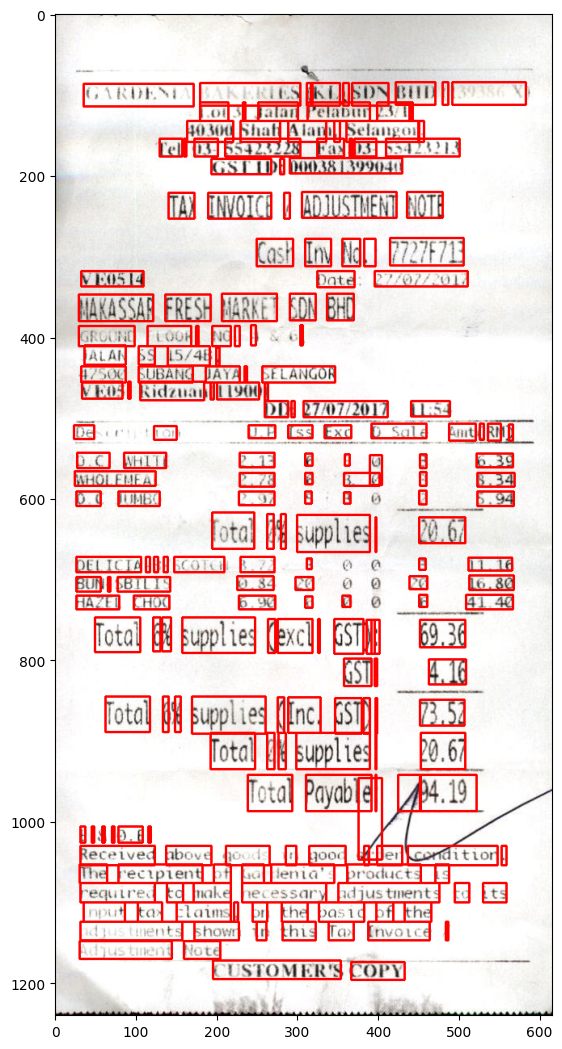

In [6]:
img = random.choice(TRAIN_IMAGES)
visualize_image(img, get_annotated_file(img))

In [7]:
x, y = generate_region_affinity_heatmap(image_path=img, fill_method="solid")
image = normalize_image(np.asarray(Image.open(img)))

Image and region map


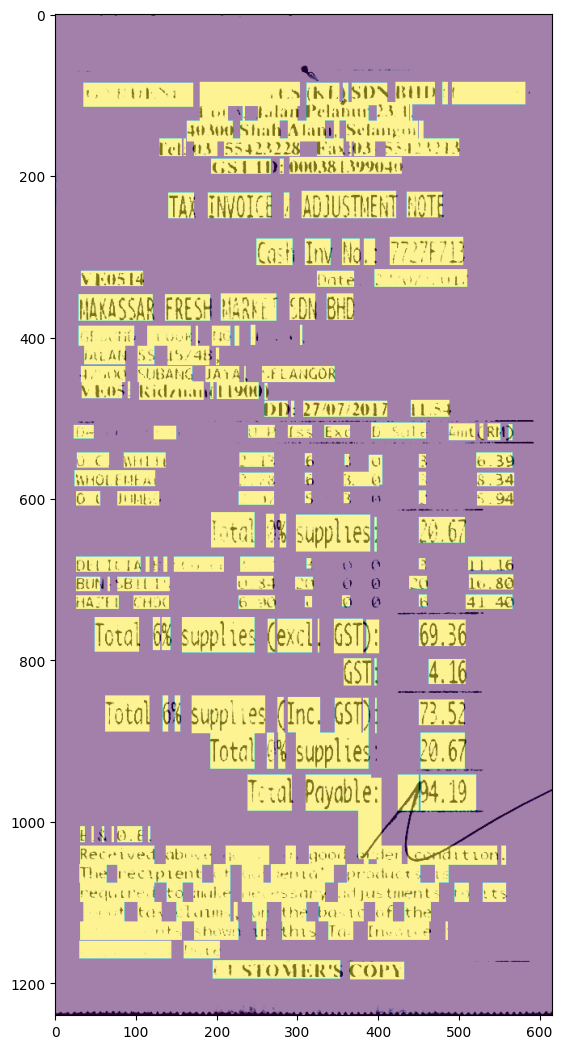

In [8]:
print("Image and region map")
visualize_ndarray_image(images=[image, x], opacity=[1, 0.5])

Image and affinity map


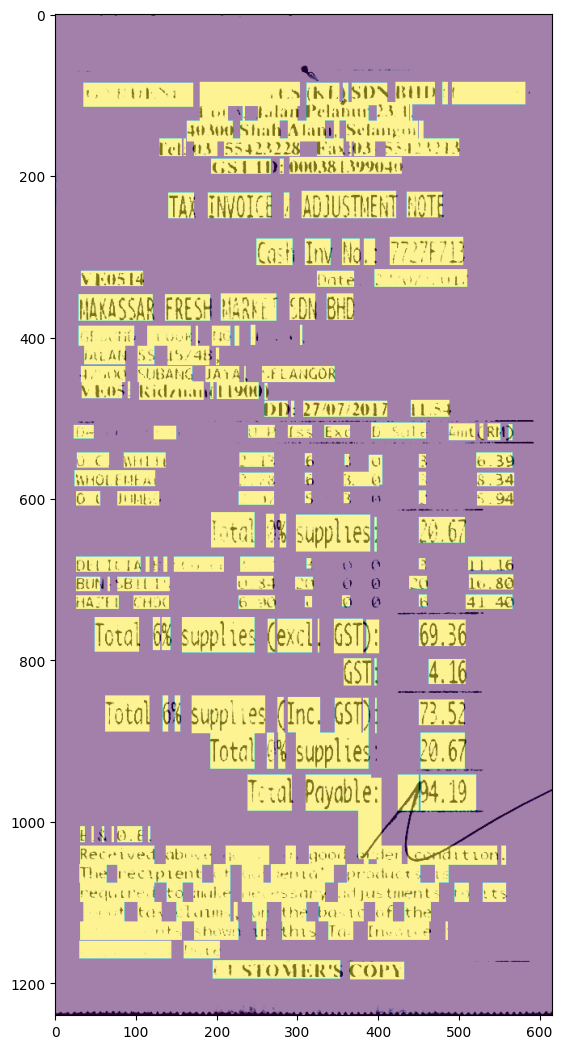

In [9]:
print("Image and affinity map")
visualize_ndarray_image(images=[image, y], opacity=[1, 0.5])

In [10]:
train_df = get_df(DATA_DIR_RAW_TRAIN)
test_df = get_df(DATA_DIR_RAW_TEST)

In [11]:
train_df.head()

,image,annotations
0,../data/raw/train/X51005442376.jpg,../data/raw/train/X51005442376_ocr.json
1,../data/raw/train/X51009453804.jpg,../data/raw/train/X51009453804_ocr.json
2,../data/raw/train/X51006401723.jpg,../data/raw/train/X51006401723_ocr.json
3,../data/raw/train/X51006913023.jpg,../data/raw/train/X51006913023_ocr.json
4,../data/raw/train/X51007846451.jpg,../data/raw/train/X51007846451_ocr.json


In [12]:
train_df, val_df = split_data(df=train_df, split_ratio=[0.9])
print(f"Length of train_df = {len(train_df)}")
print(f"Length of val_df = {len(val_df)}")
print(f"Length of test_df = {len(test_df)}")

Length of train_df = 563
Length of val_df = 63
Length of test_df = 361


In [13]:
# Get data loaders and visualize its output
data_generator = OCRData(train_data=train_df, val_data=val_df, test_data=test_df, train_batch_size=8, val_batch_size=8, test_batch_size=8)

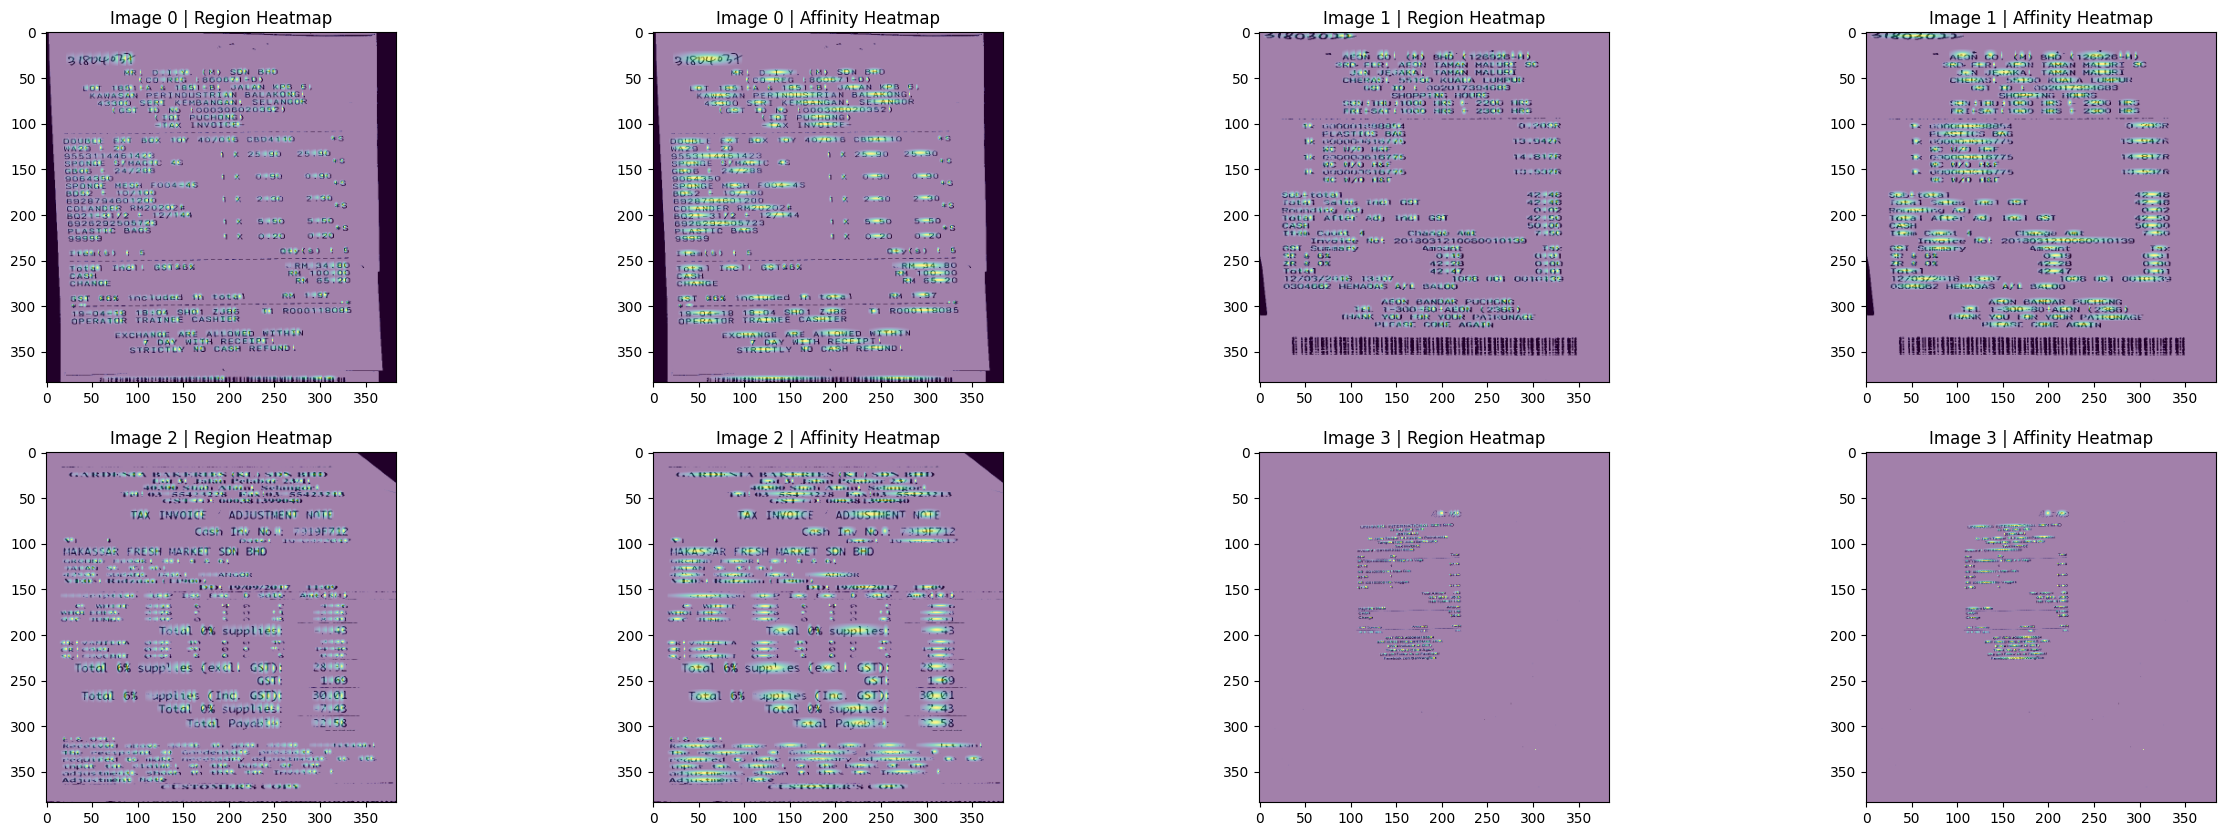

In [14]:
data_generator.visualize()

In [15]:
train_loader, val_loader, test_loader = data_generator.get_data_loaders()

### Regular training

In [17]:
model = OCRModel(
    train_loader=train_loader, 
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=nn.MSELoss(),
    device="mps",
    epochs=5,
    freeze_model=True,
    trainable_layers=[],
    save_path_dir="../logs/text_detection_logs/pytorch",
    saved_model="../src/text_detection/models/downloaded_model/craft/craft_mlt_25k.pth"
)

Model loaded from ../src/text_detection/models/downloaded_model/craft/craft_mlt_25k.pth.
Model froze...


In [18]:
model.configure_optimizers()

In [19]:
trained_model, best_model = model.train()


DEVICE - mps || EPOCHS - 5 || LEARNING RATE - 0.001.

Skipping training as model params are all frozen.


Testing model...


46it [06:19,  8.24s/it]



 TEST-LOSS - 0.02085 || TIME ELAPSED - 379.25s.



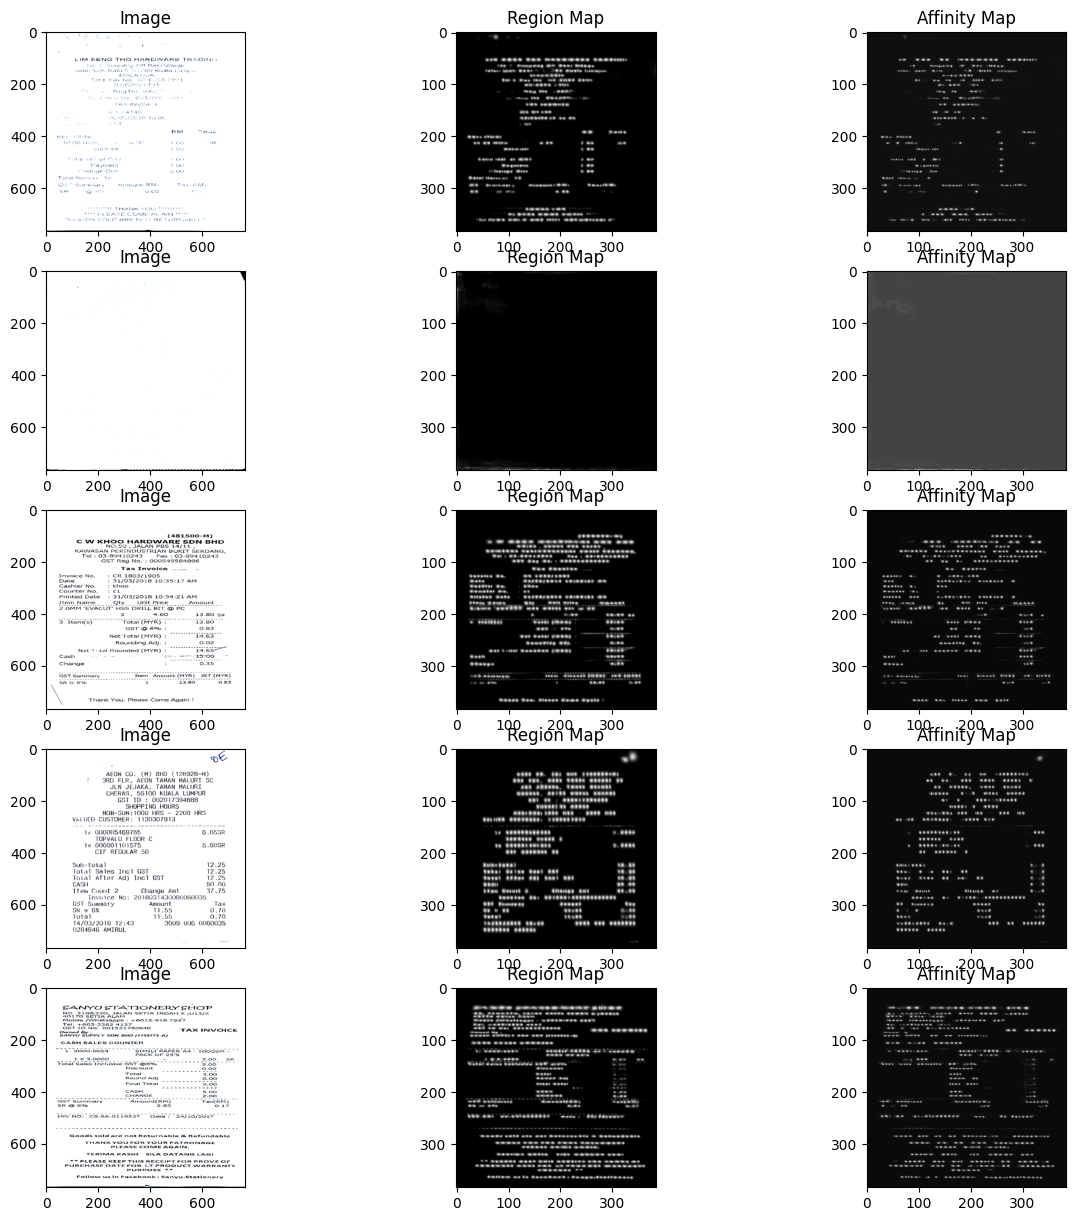

In [20]:
model.test()

### Training using pytorch lightning [Needs further tuning]

### Inference

Fetching model...
Model loaded from ../src/text_detection/models/downloaded_model/craft/craft_mlt_25k.pth.
Model froze...
Fetching images...
Inferencing...

Processing image: ../data/raw/test/X51006387660.jpg


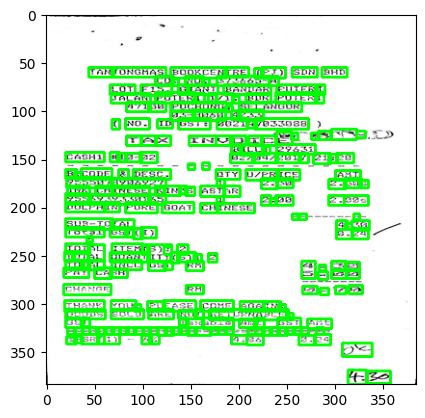


Processing image: ../data/raw/test/X51005806692.jpg


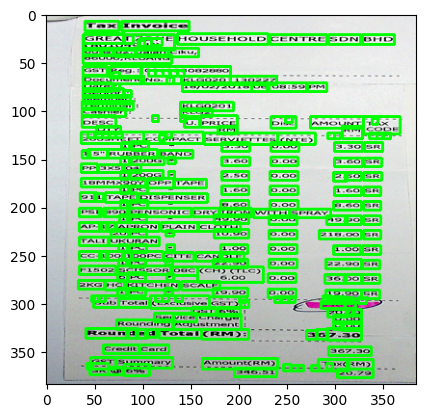

In [22]:
_ = Inference(
        saved_model="../src/text_detection/models/downloaded_model/craft/craft_mlt_25k.pth",
        input_image_directory="../data/raw/test/",
        number_of_images_to_infer=2,
        shuffle=True
).infer()